## Final Project. PYQUANT


## Models with Multi variable and different rolling periods 

### PART1 - Data Cleaning (Making variables for analysis)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\495279268.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
stocks = pd.read_feather('crsp_monthly.feather') 
cstat  = pd.read_feather('compustat.feather')
cstat2  = pd.read_csv('Additional compustat.csv', parse_dates = [2])

According to our previous lectures, we chose some variables which are closely related to future expected return of stocks. <br>
    1. Expected profitability (Gross Profit/Asset, EBIT/Asset, EBITDA/Asset)<br> 2. Valuation (Book to Market, E/P)<br> 3. Momentum (Seasonal momentum, Momentum)<br> 4. Size (Market Cap)

In [4]:
# Data cleanup process for stocks dataframe

stocks = stocks.loc[(stocks['SHRCD'] == 10)|(stocks['SHRCD'] == 11)] # Include only stocks
stocks = stocks.loc[(stocks['SHROUT'] != 0)] # Eliminate abnormal cases (shareoutstanding is zero) 

stocks['PRC']  = np.abs(stocks['PRC']) 
stocks['MV'] = stocks['SHROUT']*stocks['PRC'] # Size (Market Cap)
stocks['DATE'] = stocks['DATE'] + MonthEnd(0) 

stocks.drop(['SHRCD','EXCHCD','SICCD','VOL'], axis=1, inplace=True) 
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)

# lagged variables
stocks['lag_PRC']    = stocks['PRC'].groupby('PERMNO').shift(1)
stocks['lag_MV']     = stocks['MV'].groupby('PERMNO').shift(1)
stocks['lag_SHROUT'] = stocks['SHROUT'].groupby('PERMNO').shift(1)
stocks.head()

PRC       RET  SHROUT  DIVAMT            MV  lag_PRC  \
PERMNO  DATE                                                                    
10000.0 1986-01-31  4.375000       NaN  3680.0     NaN  16100.000000      NaN   
        1986-02-28  3.250000 -0.257143  3680.0     NaN  11960.000000   4.3750   
        1986-03-31  4.437500  0.365385  3680.0     NaN  16330.000000   3.2500   
        1986-04-30  4.000000 -0.098592  3793.0     NaN  15172.000000   4.4375   
        1986-05-31  3.109375 -0.222656  3793.0     NaN  11793.859375   4.0000   

                     lag_MV  lag_SHROUT  
PERMNO  DATE                             
10000.0 1986-01-31      NaN         NaN  
        1986-02-28  16100.0      3680.0  
        1986-03-31  11960.0      3680.0  
        1986-04-30  16330.0      3680.0  
        1986-05-31  15172.0      3793.0

In [5]:
# Data cleanup process for cstat dataframe

cstat = cstat.loc[(cstat['SEQ'] != 0)] # Eliminate SEQs of 0 (for better calculation of Book to Market without 'inf')
cstat = cstat.loc[(cstat['AT'] != 0)] # Eliminate ATs of 0 (for better calculation of GP/A, EBIT/A, EBITDA/A without 'inf')

cstat.rename(columns={"LPERMNO":"PERMNO"}, inplace=True) # rename LPERMNO to PERMNO for merge
cstat['DATE'] = cstat['DATADATE'] + MonthEnd(0) 
cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)
cstat.head()

DATADATE   FYEAR      AT    CEQ      LT  PSTK    SEQ  \
PERMNO  DATE                                                                
10000.0 1986-10-31 1986-10-31  1986.0   2.115  0.418   1.697   0.0  0.418   
10001.0 1986-06-30 1986-06-30  1986.0  12.242  5.432   6.810   0.0  5.432   
        1987-06-30 1987-06-30  1987.0  11.771  5.369   6.402   0.0  5.369   
        1988-06-30 1988-06-30  1988.0  11.735  5.512   6.223   0.0  5.512   
        1989-06-30 1989-06-30  1989.0  18.565  6.321  12.244   0.0  6.321   

                       IB   CAPX  
PERMNO  DATE                      
10000.0 1986-10-31 -0.730  0.240  
10001.0 1986-06-30  0.669  0.551  
        1987-06-30  0.312  0.513  
        1988-06-30  0.542  0.240  
        1989-06-30  1.208  0.444

In [6]:
# Merge two dataframes by using left join
stocks = stocks.merge(cstat[['AT','SEQ','IB']], how='left', on=['PERMNO','DATE']) 

In [7]:
# Data cleanup process for cstat2 dataframe

cstat2['DATE'] = pd.to_datetime(cstat2['DATE'])
cstat2.set_index(['PERMNO','DATE'], inplace=True)
cstat2.sort_index(inplace=True)
cstat2['gp'] = cstat2['gp'].astype(np.float64)
cstat2.head()

gp      at   capx   ebit  ebitda
PERMNO  DATE                                           
10000.0 1986-10-31  0.515   2.115  0.240 -0.686  -0.585
10001.0 1986-06-30  1.895  12.242  0.551  1.476   1.895
        1987-06-30  1.083  11.771  0.513  0.624   1.083
        1988-06-30  1.422  11.735  0.240  0.984   1.422
        1989-06-30  3.054  18.565  0.444  2.401   3.054

In [8]:
# Merge two dataframes by using left join
stocks = stocks.merge(cstat2[['gp','ebit','ebitda']], how='left', on=['PERMNO','DATE']) 

In [9]:
# Make lagged IB, SEQ columns to calculate Valuation ratios with current stock price
# We used 6 months lag by the assumption that all financials are disclosed in 6 months at maximum

stocks['lag_IB'] = stocks['IB'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
stocks['lag_SEQ'] = stocks['SEQ'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) 

stocks['lag_at'] = stocks['AT'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) 
stocks['lag_gp'] = stocks['gp'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
stocks['lag_ebit'] = stocks['ebit'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) 
stocks['lag_ebitda'] = stocks['ebitda'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) 

In [10]:
# Make Variables related to Valuation, Profitability, and Momentum

stocks['lag_BM'] = stocks['lag_SEQ']*1000 / stocks['MV'].groupby('PERMNO').shift() # Valuation : Book to market ratio (for regression)
stocks['lag_EP'] = stocks['lag_IB']*1000 / stocks['MV'].groupby('PERMNO').shift() # Valuation : Earnings / price ratio (for regression)

stocks['GPA'] = stocks['gp'] / stocks['AT']
stocks['EBIT_A'] = stocks['ebit'] / stocks['AT']
stocks['EBITDA_A'] = stocks['ebitda'] / stocks['AT']

stocks['lag_GPA'] = stocks['GPA'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) # Profitability : Return on Equity ratio (for regression)
stocks['lag_EBIT_A'] = stocks['EBIT_A'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) # Profitability : Return on Assets ratio (for regression)
stocks['lag_EBITDA_A'] = stocks['EBITDA_A'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15) # Profitability : Return on Assets ratio (for regression)

stocks['lag ret_2'] = stocks['RET'].groupby('PERMNO').shift(2)
stocks['momentum'] = stocks['lag ret_2'].groupby('PERMNO').rolling(9).mean().droplevel(0) # For forecast and construct portfolio

#stocks['lag_ret12'] = stocks['RET'].groupby('PERMNO').shift(12) # seasonality momentum

In [11]:
# Choosing necessary columns only

stocks = stocks[['RET', 'lag_MV', 'lag_BM', 'lag_EP', 'lag_GPA', 'lag_EBIT_A','lag_EBITDA_A', 'momentum']]
stocks.tail()

RET        lag_MV    lag_BM    lag_EP   lag_GPA  \
PERMNO  DATE                                                               
93436.0 2022-02-28 -0.070768  9.681076e+08  0.022957  0.000745  0.176133   
        2022-03-31  0.238009  8.995964e+08  0.024706  0.000801  0.176133   
        2022-04-30 -0.191945  1.116368e+09  0.019908  0.000646  0.176133   
        2022-05-31 -0.129197  9.021161e+08  0.024637  0.000799  0.176133   
        2022-06-30 -0.111888  7.855650e+08  0.038430  0.007026  0.265842   

                    lag_EBIT_A  lag_EBITDA_A  momentum  
PERMNO  DATE                                            
93436.0 2022-02-28    0.041881      0.086408  0.061505  
        2022-03-31    0.041881      0.086408  0.041976  
        2022-04-30    0.041881      0.086408  0.047303  
        2022-05-31    0.041881      0.086408  0.064067  
        2022-06-30    0.104553      0.151406  0.041513

In [12]:
stocks.describe()  # checking NaN values from the dataframe

,RET,lag_MV,lag_BM,lag_EP,lag_GPA,lag_EBIT_A,lag_EBITDA_A,momentum
count,3.097788e+06,3.117290e+06,2.835298e+06,2.843443e+06,2.892922e+06,2.792966e+06,2.879703e+06,2.848963e+06
mean,1.141520e-02,2.050129e+06,6.755277e+00,5.284964e-01,3.068479e-01,-9.255703e-05,4.197352e-02,1.255817e-02
std,1.863897e-01,1.735322e+07,4.938669e+02,7.903322e+01,3.608126e-01,5.143703e-01,4.938153e-01,5.800805e-02
min,-9.936000e-01,1.056250e+01,-6.747874e+03,-2.885975e+04,-2.930769e+01,-1.020000e+02,-1.020000e+02,-5.267206e-01
25%,-6.849315e-02,2.017969e+04,2.948256e-01,-1.934482e-02,1.001515e-01,-8.011325e-04,1.931209e-02,-1.493366e-02
50%,0.000000e+00,9.037475e+04,5.982995e-01,4.368236e-02,2.775815e-01,5.951061e-02,9.521712e-02,1.067448e-02
75%,7.228909e-02,5.091548e+05,1.095931e+00,8.936771e-02,4.716038e-01,1.180555e-01,1.605323e-01,3.670236e-02
max,2.400000e+01,2.902368e+09,3.632182e+05,3.946499e+04,1.294413e+01,1.998740e+01,1.998740e+01,2.630218e+00


In [13]:
# Dropping NaN values for Fama-Macbeth regression

stocks = stocks.dropna(subset = ['RET', 'lag_MV', 'lag_BM', 'lag_EP', 'lag_GPA', 'lag_EBIT_A','lag_EBITDA_A', 'momentum'])

In [14]:
# Reorder columns based on the 'DATE' and 'PERMNO'

stocks = stocks.reorder_levels(['DATE','PERMNO']).sort_index()
stocks.head()

RET      lag_MV    lag_BM    lag_EP   lag_GPA  \
DATE       PERMNO                                                        
1970-08-31 16117.0 -0.036782   30041.375  0.501508 -0.733222  0.067264   
           21776.0  0.032593  654667.500  0.091851  0.000791  0.027643   
           23405.0  0.039096  503844.250  6.417062  1.642373  0.306659   
           24328.0  0.027234   75217.875  1.516980  0.130075  0.588667   
           24424.0  0.040000  138312.000  0.007469 -0.003138  0.904460   

                    lag_EBIT_A  lag_EBITDA_A  momentum  
DATE       PERMNO                                       
1970-08-31 16117.0   -0.831745     -0.788407 -0.015152  
           21776.0    0.010353      0.011551 -0.009065  
           23405.0    0.124104      0.147702  0.023496  
           24328.0    0.096841      0.161611 -0.006797  
           24424.0   -0.126331     -0.079137 -0.000460

There are some extreme values in factors, so we need to limit them to proper ranges. <br>
However, as we conducted many versions of ranges, if we set ranges so narrowly, the performances of the portfolio turn out as too low. We guess that since we use a "Zero-unit portfolio," we need to short-sell some, but if we exclude stocks with somewhat extreme ratios, the performance from the short-sell side deteriorates. <br> 
Therefore, we need to set the range as not "good-looking ranges" but "ranges that do not hurt the performance of the portfolio with statistical effectiveness," even though the ranges can seem so wide.

In [15]:
stocks = stocks.loc[(stocks['lag_BM'] > - 5)]  # Book to Market range setting
stocks = stocks.loc[(stocks['lag_GPA'] > - 1)] # Gross Profit / Asset range setting
stocks['lag_BM'] = abs(stocks['lag_BM'])       # Refer to Explanation 1 in the below cell

Explanation1 (Reason for 'ABS'): BM is the factors that help find undervalued stocks. There can be some stocks with negative equity or earnings, but still have potential to recover. For these stocks, the negative BM ratio works in the opposite direction to our intention (Buy undervalued (lower market cap) stocks, and sell overvalued (higher market cap) stocks) so we make these ratios positive. As we tried different versions with this setting, it turned out that this helps improve both performance and t-stats. <br>

In [16]:
stocks.describe()

,RET,lag_MV,lag_BM,lag_EP,lag_GPA,lag_EBIT_A,lag_EBITDA_A,momentum
count,2.488251e+06,2.488251e+06,2.488251e+06,2.488251e+06,2.488251e+06,2.488251e+06,2.488251e+06,2.488251e+06
mean,1.227199e-02,2.474208e+06,2.093558e+00,7.841408e-02,3.274277e-01,2.084642e-02,6.173086e-02,1.280162e-02
std,1.862630e-01,1.936528e+07,1.832325e+02,2.150695e+01,3.048241e-01,2.821709e-01,2.676647e-01,5.837087e-02
min,-9.936000e-01,2.770312e+01,9.153399e-07,-1.562092e+03,-9.997406e-01,-8.050000e+01,-8.050000e+01,-4.749615e-01
25%,-6.835443e-02,2.474450e+04,3.059025e-01,-1.577308e-02,1.221358e-01,8.369012e-03,2.358038e-02,-1.522703e-02
50%,0.000000e+00,1.178493e+05,5.898512e-01,4.318460e-02,2.947094e-01,6.360910e-02,1.019677e-01,1.051952e-02
75%,7.395498e-02,6.726644e+05,1.054991e+00,8.524529e-02,4.830939e-01,1.207909e-01,1.655613e-01,3.690989e-02
max,2.400000e+01,2.902368e+09,1.037385e+05,9.698115e+03,1.097761e+01,1.998740e+01,1.998740e+01,2.630218e+00


### PART2 - Building Fama-Macbeth regression modesl by using various combinations of variables and periods

In [17]:
# Making necessary functions for qunitile assignment, high minus low portfolio, Performance evaluation

def quintiles(inser):
    return pd.qcut(inser, q=10, labels=False, duplicates = 'drop')

def perf(epvar): 
    stocks['Q'] = stocks[epvar].groupby('DATE').apply(quintiles) 
    ports = stocks.groupby(['Q', 'DATE'])['RET'].mean()   
    print(ports.groupby('Q').describe()) 
    hml = ports.loc[9] - ports.loc[0]  # high - low portfolio 
    return hml
    
def stats(hml):
    stats = hml.describe()
    stats.loc['Annual Ret'] = stats.loc['mean'] * 12
    stats.loc['tstat'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)
    
    performance = pd.DataFrame(index=hml.index)
    performance['port_ret'] = hml
    performance['cumprod'] = (performance['port_ret']+1).cumprod()
    performance['cummax'] = performance['cumprod'].cummax()
    performance['drawdown'] = -(performance['cumprod']/performance['cummax'] - 1)
    stats.loc['Max DD'] = performance['drawdown'].max()
    
    performance['minX'] = 0
    performance.loc[performance['port_ret']<0, 'minX'] = performance['port_ret']
    DDeviation = np.sqrt(12) * (performance['minX']**2).mean() ** .5
    stats.loc['STDEV_Annual'] = stats.loc['std'] * np.sqrt(12)
    stats.loc['Downside Deviation_Annual'] = DDeviation
    stats.loc['Sortino'] =  stats.loc['mean'] * 12 / DDeviation
    
    return stats

In [18]:
# Fama-Macbeth regression    
def regfun(df, mod):
    results = smf.ols(mod, data=df).fit()
    return results.params

In [19]:
# Fama-Macbeth regression with 7 variables

allparams = stocks.groupby('DATE').apply(regfun, 'RET ~ lag_MV + lag_BM + lag_EP + lag_GPA + lag_EBIT_A + lag_EBITDA_A + momentum')

In [20]:
# Check the statistical importance of each variable

FMstats = allparams.describe()
FMstats.loc['stderr'] = FMstats.loc['std'] / np.sqrt(FMstats.loc['count'])
FMstats.loc['tstat']  = FMstats.loc['mean'] / FMstats.loc['stderr']
print(FMstats)   

         Intercept        lag_MV      lag_BM      lag_EP     lag_GPA  \
count   623.000000  6.230000e+02  623.000000  623.000000  623.000000   
mean      0.006636 -1.229118e-10    0.001683   -0.004006    0.005652   
std       0.054304  4.092835e-09    0.005733    0.020574    0.031027   
min      -0.283743 -3.412792e-08   -0.015053   -0.213906   -0.107601   
25%      -0.023052 -4.971466e-10   -0.000469   -0.007292   -0.013253   
50%       0.008908 -1.466200e-11    0.000397   -0.000463    0.004252   
75%       0.038651  3.939542e-10    0.002460    0.003741    0.022253   
max       0.236892  6.421696e-08    0.047090    0.091258    0.191084   
stderr    0.002176  1.639760e-10    0.000230    0.000824    0.001243   
tstat     3.050102 -7.495719e-01    7.327225   -4.860515    4.547096   

        lag_EBIT_A  lag_EBITDA_A    momentum  
count   623.000000    623.000000  623.000000  
mean     -0.018674      0.022965    0.033349  
std       0.220642      0.207200    0.347095  
min      -1.483183 

We can check the statistical importance of each variable by checking the t-statistics values. <br>
We chose the most important variables in three categories(Valuation, Profitability, and momentum). <br>
Three variables are lag_BM, lag_GPA, and momentum. And We're going to take two of these three variables and create three regression models. (1. RET~lag_BM + lag_GPA, 2. RET~lag_BM + momentum, 3. RET~lag_GPA + momentum) 

In [21]:
# Model1 : RET ~ lag_BM + lag_GPA
allparams1 = stocks.groupby('DATE').apply(regfun, 'RET ~ lag_BM + lag_GPA')

In [22]:
FMstats = allparams1.describe()
FMstats.loc['stderr'] = FMstats.loc['std'] / np.sqrt(FMstats.loc['count'])
FMstats.loc['tstat']  = FMstats.loc['mean'] / FMstats.loc['stderr']
print(FMstats) # Both variables looks important

         Intercept      lag_BM     lag_GPA
count   623.000000  623.000000  623.000000
mean      0.008878    0.001300    0.006582
std       0.059638    0.007027    0.027839
min      -0.288519   -0.045242   -0.101864
25%      -0.024488   -0.000348   -0.010045
50%       0.009829    0.000035    0.008272
75%       0.043109    0.001932    0.023929
max       0.291992    0.068757    0.096338
stderr    0.002389    0.000282    0.001115
tstat     3.715752    4.619158    5.901073


In [23]:
# Model2 : RET ~ lag_BM + momentum
allparams2 = stocks.groupby('DATE').apply(regfun, 'RET ~ lag_BM + momentum')

In [24]:
FMstats = allparams2.describe()
FMstats.loc['stderr'] = FMstats.loc['std'] / np.sqrt(FMstats.loc['count'])
FMstats.loc['tstat']  = FMstats.loc['mean'] / FMstats.loc['stderr']
print(FMstats) # Both variables looks important

         Intercept      lag_BM    momentum
count   623.000000  623.000000  623.000000
mean      0.009798    0.001487    0.036405
std       0.055564    0.006320    0.386457
min      -0.282467   -0.016136   -2.839528
25%      -0.021370   -0.000255   -0.090481
50%       0.013107    0.000059    0.051845
75%       0.041527    0.001772    0.201985
max       0.208741    0.070376    2.483886
stderr    0.002226    0.000253    0.015483
tstat     4.401238    5.874344    2.351273


In [25]:
# Model3 : RET ~ lag_GPA + momentum
allparams3 = stocks.groupby('DATE').apply(regfun, 'RET ~ lag_GPA + momentum')

In [26]:
FMstats = allparams3.describe()
FMstats.loc['stderr'] = FMstats.loc['std'] / np.sqrt(FMstats.loc['count'])
FMstats.loc['tstat']  = FMstats.loc['mean'] / FMstats.loc['stderr']
print(FMstats) # Both variables looks important

         Intercept     lag_GPA    momentum
count   623.000000  623.000000  623.000000
mean      0.009318    0.005941    0.022512
std       0.056566    0.027151    0.385796
min      -0.280181   -0.107150   -3.137866
25%      -0.022492   -0.010401   -0.106669
50%       0.010518    0.006881    0.045176
75%       0.042609    0.022306    0.196002
max       0.209046    0.100196    2.050404
stderr    0.002266    0.001088    0.015457
tstat     4.111652    5.461789    1.456464


In [27]:
# Change column names for allparams2 and allparams3
allparams2.columns = ['Intercept2', 'lag_BM2', 'momentum2']  
allparams3.columns = ['Intercept3', 'lag_GPA3', 'momentum3']


In [28]:
# Building new functions : Deciding rolling period, calculate coefficient average, and make a dataframe

def rollparams(months):
    new_df1 = allparams1.rolling(months).mean().shift()
    new_df2 = allparams2.rolling(months).mean().shift()
    new_df3 = allparams3.rolling(months).mean().shift()

    
    columnlist1 = []
    for i in range(len(allparams1.columns)):
        columnlist1.append(allparams1.columns[i] + '_coef_'  + str(months))
    
    columnlist2 = []
    for i in range(len(allparams2.columns)):
        columnlist2.append(allparams2.columns[i] + '_coef_'  + str(months))

    columnlist3 = []
    for i in range(len(allparams3.columns)):
        columnlist3.append(allparams3.columns[i] + '_coef_'  + str(months))
        
        
    new_df1.columns = columnlist1
    new_df2.columns = columnlist2
    new_df3.columns = columnlist3    
    
    new_df_tentative = pd.merge(new_df1, new_df2, how='left', on='DATE')
    new_df = pd.merge(new_df_tentative, new_df3, how='left', on='DATE')    
    
    return new_df

In [29]:
# Testing the rollparams function

rollparams(120).tail()

,Intercept_coef_120,lag_BM_coef_120,lag_GPA_coef_120,Intercept2_coef_120,lag_BM2_coef_120,momentum2_coef_120,Intercept3_coef_120,lag_GPA3_coef_120,momentum3_coef_120
DATE,,,,,,,,,
2022-02-28,0.009967,0.001462,0.005043,0.010347,0.001480,0.024900,0.010900,0.004278,0.017821
2022-03-31,0.009621,0.001452,0.004946,0.010008,0.001480,0.028393,0.010585,0.004100,0.021438
2022-04-30,0.009601,0.001453,0.004469,0.009887,0.001481,0.025857,0.010538,0.003649,0.019024
2022-05-31,0.008670,0.001451,0.005018,0.009150,0.001487,0.031314,0.009721,0.004113,0.024361
2022-06-30,0.009073,0.001445,0.005191,0.009670,0.001478,0.033226,0.010200,0.004253,0.026297


In [30]:
# We will add columns for different rolling periods (10, 8, 6, and 4 years)

period = [120, 96, 72, 48] # ten to four years
rollparams_stat = pd.DataFrame(index=allparams1.index)

for p in period:
    rollparams_stat = rollparams_stat.merge(rollparams(p), how='left', on='DATE')

rollparams_stat.tail()     

# Now we have 3 combination of variables * 4 different periods = 12 models' coefficient columns in rollparams_stat dataframe   

,Intercept_coef_120,lag_BM_coef_120,lag_GPA_coef_120,Intercept2_coef_120,lag_BM2_coef_120,momentum2_coef_120,Intercept3_coef_120,lag_GPA3_coef_120,momentum3_coef_120,Intercept_coef_96,...,momentum3_coef_72,Intercept_coef_48,lag_BM_coef_48,lag_GPA_coef_48,Intercept2_coef_48,lag_BM2_coef_48,momentum2_coef_48,Intercept3_coef_48,lag_GPA3_coef_48,momentum3_coef_48
DATE,,,,,,,,,,,,,,,,,,,,,
2022-02-28,0.009967,0.001462,0.005043,0.010347,0.001480,0.024900,0.010900,0.004278,0.017821,0.007440,...,0.000637,0.007613,0.002301,0.011834,0.009129,0.002253,0.043426,0.009235,0.010486,0.031469
2022-03-31,0.009621,0.001452,0.004946,0.010008,0.001480,0.028393,0.010585,0.004100,0.021438,0.006917,...,0.007536,0.008519,0.002249,0.011132,0.009956,0.002207,0.046172,0.010198,0.009633,0.034776
2022-04-30,0.009601,0.001453,0.004469,0.009887,0.001481,0.025857,0.010538,0.003649,0.019024,0.007236,...,0.016869,0.009057,0.002168,0.009544,0.010101,0.002155,0.048621,0.010600,0.008081,0.037962
2022-05-31,0.008670,0.001451,0.005018,0.009150,0.001487,0.031314,0.009721,0.004113,0.024361,0.006341,...,0.035971,0.006320,0.002147,0.010880,0.007896,0.002147,0.062843,0.008201,0.009167,0.051734
2022-06-30,0.009073,0.001445,0.005191,0.009670,0.001478,0.033226,0.010200,0.004253,0.026297,0.006030,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.007070,0.009022,0.056998


In [31]:
# Merging two dataframes (stocks and rollparams_stat)

stocks = stocks.reset_index() 
stocks.set_index('DATE', inplace=True) 
stocks = pd.merge(stocks, rollparams_stat, how='left', on='DATE')
stocks.tail()

,PERMNO,RET,lag_MV,lag_BM,lag_EP,lag_GPA,lag_EBIT_A,lag_EBITDA_A,momentum,Intercept_coef_120,...,momentum3_coef_72,Intercept_coef_48,lag_BM_coef_48,lag_GPA_coef_48,Intercept2_coef_48,lag_BM2_coef_48,momentum2_coef_48,Intercept3_coef_48,lag_GPA3_coef_48,momentum3_coef_48
DATE,,,,,,,,,,,,,,,,,,,,,
2022-06-30,93423.0,-0.260647,2.537102e+06,0.387135,0.051209,0.245176,0.135422,0.173970,-0.005207,0.009073,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.00707,0.009022,0.056998
2022-06-30,93426.0,-0.041776,3.836784e+05,0.722217,0.052703,0.316139,0.076304,0.108771,-0.014928,0.009073,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.00707,0.009022,0.056998
2022-06-30,93429.0,0.007835,1.192609e+07,0.302262,0.044357,0.216612,0.120156,0.144721,-0.002923,0.009073,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.00707,0.009022,0.056998
2022-06-30,93434.0,-0.212598,5.278120e+04,1.410048,-0.363216,0.090295,-0.146272,-0.110160,-0.060747,0.009073,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.00707,0.009022,0.056998
2022-06-30,93436.0,-0.111888,7.855650e+08,0.038430,0.007026,0.265842,0.104553,0.151406,0.041513,0.009073,...,0.038291,0.005041,0.002049,0.010796,0.006796,0.002044,0.067668,0.00707,0.009022,0.056998


### PART3 - Calculating predicted return on each stock for each date, setting a criteria for selecting the best model

In [32]:
# 1. Calculating Predicted returns by using 12 different FM regression models 
# 2. Calculating the difference between actual return and predicted returns
# 3. Add the predicted returns and the difference to Stocks dataframe
    
period = [120, 96, 72, 48] 

for p in period:
    fmpred_p1 = stocks[rollparams(p).columns[0]] # Intercept_coef_
    
    for i in range(1, len(allparams1.columns)): 
        fmpred_p1 = fmpred_p1 + ( stocks[rollparams(p).columns[i]] * stocks[rollparams(p).columns[i].split("_c")[0]] ) # coefficient * variable name

        stocks['fmpred1_'+ str(p)] = fmpred_p1
        stocks['fmpred1_diff_'+ str(p)] = stocks['RET'] - fmpred_p1

for p in period:
    fmpred_p2 = stocks[rollparams(p).columns[len(allparams1.columns)]] # Intercept_coef_
    
    for i in range(len(allparams1.columns)+1, len(allparams1.columns)+len(allparams2.columns)): 
        fmpred_p2 = fmpred_p2 + ( stocks[rollparams(p).columns[i]] * stocks[rollparams(p).columns[i].split("2_")[0]] ) # coefficient * variable name

        stocks['fmpred2_'+ str(p)] = fmpred_p2      
        stocks['fmpred2_diff_'+ str(p)] = stocks['RET'] - fmpred_p2

for p in period:
    fmpred_p3 = stocks[rollparams(p).columns[len(allparams1.columns)+len(allparams2.columns)]] # Intercept_coef_)
    
    for i in range(len(allparams1.columns)+len(allparams2.columns)+1, len(rollparams(p).columns)): 
        fmpred_p3 = fmpred_p3 + ( stocks[rollparams(p).columns[i]] * stocks[rollparams(p).columns[i].split("3_")[0]] ) # coefficient * variable name

        stocks['fmpred3_'+ str(p)] = fmpred_p3      
        stocks['fmpred3_diff_'+ str(p)] = stocks['RET'] - fmpred_p3

In [33]:
stocks.tail()

,PERMNO,RET,lag_MV,lag_BM,lag_EP,lag_GPA,lag_EBIT_A,lag_EBITDA_A,momentum,Intercept_coef_120,...,fmpred2_48,fmpred2_diff_48,fmpred3_120,fmpred3_diff_120,fmpred3_96,fmpred3_diff_96,fmpred3_72,fmpred3_diff_72,fmpred3_48,fmpred3_diff_48
DATE,,,,,,,,,,,,,,,,,,,,,
2022-06-30,93423.0,-0.260647,2.537102e+06,0.387135,0.051209,0.245176,0.135422,0.173970,-0.005207,0.009073,...,0.007235,-0.267883,0.011106,-0.271753,0.008623,-0.269270,0.011501,-0.272148,0.008985,-0.269632
2022-06-30,93426.0,-0.041776,3.836784e+05,0.722217,0.052703,0.316139,0.076304,0.108771,-0.014928,0.009073,...,0.007263,-0.049039,0.011152,-0.052928,0.008786,-0.050562,0.011629,-0.053406,0.009071,-0.050847
2022-06-30,93429.0,0.007835,1.192609e+07,0.302262,0.044357,0.216612,0.120156,0.144721,-0.002923,0.009073,...,0.007216,0.000619,0.011044,-0.003209,0.008511,-0.000676,0.011387,-0.003551,0.008857,-0.001022
2022-06-30,93434.0,-0.212598,5.278120e+04,1.410048,-0.363216,0.090295,-0.146272,-0.110160,-0.060747,0.009073,...,0.005568,-0.218167,0.008987,-0.221585,0.006116,-0.218714,0.008281,-0.220879,0.004422,-0.217020
2022-06-30,93436.0,-0.111888,7.855650e+08,0.038430,0.007026,0.265842,0.104553,0.151406,0.041513,0.009073,...,0.009684,-0.121572,0.012422,-0.124310,0.010059,-0.121946,0.013436,-0.125323,0.011834,-0.123722


In [34]:
# Dropping NaN values

stocks_result = stocks.dropna(subset=['RET','fmpred1_120','fmpred1_96','fmpred1_72','fmpred1_48','fmpred2_120','fmpred2_96','fmpred2_72','fmpred2_48',\
                                     'fmpred3_120','fmpred3_96','fmpred3_72','fmpred3_48'])

In [35]:
# Slicing only necessary columns

stocks_fmpred = stocks_result[['RET','PERMNO','fmpred1_120','fmpred1_96','fmpred1_72','fmpred1_48',\
                               'fmpred2_120','fmpred2_96','fmpred2_72','fmpred2_48',\
                               'fmpred3_120','fmpred3_96','fmpred3_72','fmpred3_48',\
                               'fmpred1_diff_120','fmpred1_diff_96','fmpred1_diff_72','fmpred1_diff_48',\
                               'fmpred2_diff_120','fmpred2_diff_96','fmpred2_diff_72','fmpred2_diff_48',\
                               'fmpred3_diff_120','fmpred3_diff_96','fmpred3_diff_72','fmpred3_diff_48']]

In [36]:
stocks_fmpred = stocks_fmpred.reset_index()
stocks_fmpred.set_index(['PERMNO','DATE'], inplace=True)
stocks_fmpred.sort_index(inplace=True)

We are going to make additional criteria for selecting the best model out of 12 models.
<br>
1. Model with the best predicted return<br>
2. Model with minimum difference between actual and predicted return (lagged value)<br>
3. Model with minimum 6 months volatility of predicted return (lagged value)<br>
4. Model with maximum value of predicticed return / lagged 6 months volatility of predicted return

In [37]:
# Making columns for lagged predicted return difference

stocks_fmpred['lag_fmpred1_diff_120'] = stocks_fmpred['fmpred1_diff_120'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred1_diff_96'] = stocks_fmpred['fmpred1_diff_96'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred1_diff_72'] = stocks_fmpred['fmpred1_diff_72'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred1_diff_48'] = stocks_fmpred['fmpred1_diff_48'].groupby('PERMNO').shift(1)

stocks_fmpred['lag_fmpred2_diff_120'] = stocks_fmpred['fmpred2_diff_120'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred2_diff_96'] = stocks_fmpred['fmpred2_diff_96'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred2_diff_72'] = stocks_fmpred['fmpred2_diff_72'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred2_diff_48'] = stocks_fmpred['fmpred2_diff_48'].groupby('PERMNO').shift(1)

stocks_fmpred['lag_fmpred3_diff_120'] = stocks_fmpred['fmpred3_diff_120'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred3_diff_96'] = stocks_fmpred['fmpred3_diff_96'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred3_diff_72'] = stocks_fmpred['fmpred3_diff_72'].groupby('PERMNO').shift(1)
stocks_fmpred['lag_fmpred3_diff_48'] = stocks_fmpred['fmpred3_diff_48'].groupby('PERMNO').shift(1)

In [38]:
# Making columns for lagged 6 months volatility of predicted return 

stocks_fmpred['lag_fmpred1_std6_120'] = stocks_fmpred['fmpred1_diff_120'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred1_std6_96'] = stocks_fmpred['fmpred1_diff_96'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred1_std6_72'] = stocks_fmpred['fmpred1_diff_72'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred1_std6_48'] = stocks_fmpred['fmpred1_diff_48'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)

stocks_fmpred['lag_fmpred2_std6_120'] = stocks_fmpred['fmpred2_diff_120'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred2_std6_96'] = stocks_fmpred['fmpred2_diff_96'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred2_std6_72'] = stocks_fmpred['fmpred2_diff_72'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred2_std6_48'] = stocks_fmpred['fmpred2_diff_48'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)

stocks_fmpred['lag_fmpred3_std6_120'] = stocks_fmpred['fmpred3_diff_120'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred3_std6_96'] = stocks_fmpred['fmpred3_diff_96'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred3_std6_72'] = stocks_fmpred['fmpred3_diff_72'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)
stocks_fmpred['lag_fmpred3_std6_48'] = stocks_fmpred['fmpred3_diff_48'].groupby('PERMNO').rolling(6).std().shift(1).reset_index(level=0, drop=True)

In [39]:
# Making columns for lagged predicted return / 6 months volatility of predicted return 

stocks_fmpred['lag_fmpred1_preddivstd6_120'] = stocks_fmpred['fmpred1_120'] / stocks_fmpred['lag_fmpred1_std6_120']
stocks_fmpred['lag_fmpred1_preddivstd6_96'] = stocks_fmpred['fmpred1_96'] / stocks_fmpred['lag_fmpred1_std6_96']
stocks_fmpred['lag_fmpred1_preddivstd6_72'] = stocks_fmpred['fmpred1_72'] / stocks_fmpred['lag_fmpred1_std6_72']
stocks_fmpred['lag_fmpred1_preddivstd6_48'] = stocks_fmpred['fmpred1_48'] / stocks_fmpred['lag_fmpred1_std6_48']

stocks_fmpred['lag_fmpred2_preddivstd6_120'] = stocks_fmpred['fmpred2_120'] / stocks_fmpred['lag_fmpred2_std6_120']
stocks_fmpred['lag_fmpred2_preddivstd6_96'] = stocks_fmpred['fmpred2_96'] / stocks_fmpred['lag_fmpred2_std6_96']
stocks_fmpred['lag_fmpred2_preddivstd6_72'] = stocks_fmpred['fmpred2_72'] / stocks_fmpred['lag_fmpred2_std6_72']
stocks_fmpred['lag_fmpred2_preddivstd6_48'] = stocks_fmpred['fmpred2_48'] / stocks_fmpred['lag_fmpred2_std6_48']

stocks_fmpred['lag_fmpred3_preddivstd6_120'] = stocks_fmpred['fmpred3_120'] / stocks_fmpred['lag_fmpred3_std6_120']
stocks_fmpred['lag_fmpred3_preddivstd6_96'] = stocks_fmpred['fmpred3_96'] / stocks_fmpred['lag_fmpred3_std6_96']
stocks_fmpred['lag_fmpred3_preddivstd6_72'] = stocks_fmpred['fmpred3_72'] / stocks_fmpred['lag_fmpred3_std6_72']
stocks_fmpred['lag_fmpred3_preddivstd6_48'] = stocks_fmpred['fmpred3_48'] / stocks_fmpred['lag_fmpred3_std6_48']

In [40]:
stocks_fmpred = stocks_fmpred.reset_index() 
stocks_fmpred.set_index('DATE', inplace=True) 
stocks_fmpred.sort_index(inplace=True)

In [41]:
# Dropping NaN values
stocks_fmpred = stocks_fmpred.dropna(subset=['RET','PERMNO','fmpred1_120','fmpred1_96','fmpred1_72','fmpred1_48',\
                                             'fmpred2_120','fmpred2_96','fmpred2_72','fmpred2_48',\
                                             'fmpred3_120','fmpred3_96','fmpred3_72','fmpred3_48',\
                                             'fmpred1_diff_120','fmpred1_diff_96','fmpred1_diff_72','fmpred1_diff_48',\
                                             'fmpred2_diff_120','fmpred2_diff_96','fmpred2_diff_72','fmpred2_diff_48',\
                                             'fmpred3_diff_120','fmpred3_diff_96','fmpred3_diff_72','fmpred3_diff_48',\
                                             'lag_fmpred1_diff_120','lag_fmpred1_diff_96','lag_fmpred1_diff_72','lag_fmpred1_diff_48',\
                                             'lag_fmpred2_diff_120','lag_fmpred2_diff_96','lag_fmpred2_diff_72','lag_fmpred2_diff_48',\
                                             'lag_fmpred3_diff_120','lag_fmpred3_diff_96','lag_fmpred3_diff_72','lag_fmpred3_diff_48'])

In [42]:
stocks_fmpred = stocks_fmpred.dropna(subset=['lag_fmpred1_std6_120','lag_fmpred2_std6_120','lag_fmpred3_std6_120'])

In [43]:
# Deciding the best predicted return number

stocks_fmpred['fmpred_bestret'] = stocks_fmpred[['fmpred1_120','fmpred1_96','fmpred1_72','fmpred1_48',\
                                                 'fmpred2_120','fmpred2_96','fmpred2_72','fmpred2_48',\
                                                 'fmpred3_120','fmpred3_96','fmpred3_72','fmpred3_48']].max(axis = 1)

In [44]:
# Deciding the minimum difference number

stocks_fmpred['fmpred_minimumdiff'] = stocks_fmpred[['lag_fmpred1_diff_120','lag_fmpred1_diff_96','lag_fmpred1_diff_72','lag_fmpred1_diff_48',\
                                                     'lag_fmpred2_diff_120','lag_fmpred2_diff_96','lag_fmpred2_diff_72','lag_fmpred2_diff_48',\
                                                     'lag_fmpred3_diff_120','lag_fmpred3_diff_96','lag_fmpred3_diff_72','lag_fmpred3_diff_48']].min(axis = 1)

In [45]:
# Deciding the minimum 6 months volatility number

stocks_fmpred['fmpred_minimumstd6'] = stocks_fmpred[['lag_fmpred1_std6_120','lag_fmpred1_std6_96','lag_fmpred1_std6_72','lag_fmpred1_std6_48',\
                                                     'lag_fmpred2_std6_120','lag_fmpred2_std6_96','lag_fmpred2_std6_72','lag_fmpred2_std6_48',\
                                                     'lag_fmpred3_std6_120','lag_fmpred3_std6_96','lag_fmpred3_std6_72','lag_fmpred3_std6_48']].min(axis = 1)

In [46]:
# Deciding the maximum predicted value / 6 months volatility number

stocks_fmpred['fmpred_preddivstd6'] = stocks_fmpred[['lag_fmpred1_preddivstd6_120','lag_fmpred1_preddivstd6_96',\
                                                     'lag_fmpred1_preddivstd6_72','lag_fmpred1_preddivstd6_48',\
                                                     'lag_fmpred2_preddivstd6_120','lag_fmpred2_preddivstd6_96',\
                                                     'lag_fmpred2_preddivstd6_72','lag_fmpred2_preddivstd6_48',\
                                                    'lag_fmpred3_preddivstd6_120','lag_fmpred3_preddivstd6_96',\
                                                     'lag_fmpred3_preddivstd6_72','lag_fmpred3_preddivstd6_48']].max(axis = 1)

In [47]:
stocks_fmpred['bestret_period_model'] = np.nan
stocks_fmpred['minimumdiff_period_model'] = np.nan
stocks_fmpred['minimumdiff_ret'] = np.nan
stocks_fmpred['minimumstd6_period_model'] = np.nan
stocks_fmpred['minimumstd6_ret'] = np.nan
stocks_fmpred['preddivstd6_period_model'] = np.nan
stocks_fmpred['preddivstd6_ret'] = np.nan

In [48]:
# Deciding the best models based on criteria

for p in period:
    
    stocks_fmpred['bestret_period_model'].loc[(stocks_fmpred['fmpred_bestret'] == stocks_fmpred['fmpred1_'+str(p)])] = str(p) + '_1'
    stocks_fmpred['bestret_period_model'].loc[(stocks_fmpred['fmpred_bestret'] == stocks_fmpred['fmpred2_'+str(p)])] = str(p) + '_2'
    stocks_fmpred['bestret_period_model'].loc[(stocks_fmpred['fmpred_bestret'] == stocks_fmpred['fmpred3_'+str(p)])] = str(p) + '_3'    
    
    stocks_fmpred['minimumdiff_period_model'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = str(p) + '_1'
    stocks_fmpred['minimumdiff_period_model'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])] = str(p) + '_2'    
    stocks_fmpred['minimumdiff_period_model'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])] = str(p) + '_3'   
    
    stocks_fmpred['minimumstd6_period_model'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred1_std6_'+str(p)])] = str(p) + '_1'
    stocks_fmpred['minimumstd6_period_model'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred2_std6_'+str(p)])] = str(p) + '_2' 
    stocks_fmpred['minimumstd6_period_model'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred3_std6_'+str(p)])] = str(p) + '_3' 
    
    stocks_fmpred['preddivstd6_period_model'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred1_preddivstd6_'+str(p)])] = str(p) + '_1'
    stocks_fmpred['preddivstd6_period_model'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred2_preddivstd6_'+str(p)])] = str(p) + '_2' 
    stocks_fmpred['preddivstd6_period_model'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred3_preddivstd6_'+str(p)])] = str(p) + '_3' 


C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\3499875205.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumdiff_period_model'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = str(p) + '_1'
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\3499875205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumstd6_period_model'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred1_std6_'+str(p)])] = str(p) + '_1'
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\3499875205.py:17: SettingWithCopyWarning: 
A value is 

In [49]:
# Making columns for the best criteria predicted returns

for p in period:
    
    stocks_fmpred['minimumdiff_ret'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])]
    stocks_fmpred['minimumdiff_ret'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])] = stocks_fmpred['fmpred2_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])]
    stocks_fmpred['minimumdiff_ret'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])] = stocks_fmpred['fmpred3_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])] 
    
    stocks_fmpred['minimumstd6_ret'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred1_std6_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred1_std6_'+str(p)])]
    stocks_fmpred['minimumstd6_ret'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred2_std6_'+str(p)])] = stocks_fmpred['fmpred2_' + str(p)].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred2_std6_'+str(p)])]
    stocks_fmpred['minimumstd6_ret'].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred3_std6_'+str(p)])] = stocks_fmpred['fmpred3_' + str(p)].loc[(stocks_fmpred['fmpred_minimumstd6'] == stocks_fmpred['lag_fmpred3_std6_'+str(p)])]
    
    stocks_fmpred['preddivstd6_ret'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred1_preddivstd6_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred1_preddivstd6_'+str(p)])]
    stocks_fmpred['preddivstd6_ret'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred2_preddivstd6_'+str(p)])] = stocks_fmpred['fmpred2_' + str(p)].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred2_preddivstd6_'+str(p)])]
    stocks_fmpred['preddivstd6_ret'].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred3_preddivstd6_'+str(p)])] = stocks_fmpred['fmpred3_' + str(p)].loc[(stocks_fmpred['fmpred_preddivstd6'] == stocks_fmpred['lag_fmpred3_preddivstd6_'+str(p)])]
    
    

C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\995791114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumdiff_ret'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])]
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\995791114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumdiff_ret'].loc[(stocks_fmpred['fmpred_minimumdiff'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])] = stocks_fmpred['fmpred2_' + str(

In [50]:
# Deciding the best FM prediction period, model (individually)

stocks_fmpred['bestret_period'] = stocks_fmpred['bestret_period_model'].str.slice(start=0, stop=-2)
stocks_fmpred['bestret_period'] = stocks_fmpred['bestret_period'].astype('int64')

stocks_fmpred['bestret_model'] = stocks_fmpred['bestret_period_model'].str.slice(start=-1)
stocks_fmpred['bestret_model'] = stocks_fmpred['bestret_model'].astype('int64')

stocks_fmpred['minimumdiff_period'] = stocks_fmpred['minimumdiff_period_model'].str.slice(start=0, stop=-2)
stocks_fmpred['minimumdiff_period'] = stocks_fmpred['minimumdiff_period'].astype('int64')

stocks_fmpred['minimumdiff_model'] = stocks_fmpred['minimumdiff_period_model'].str.slice(start=-1)
stocks_fmpred['minimumdiff_model'] = stocks_fmpred['minimumdiff_model'].astype('int64')

stocks_fmpred['minimumstd6_period'] = stocks_fmpred['minimumstd6_period_model'].str.slice(start=0, stop=-2)
stocks_fmpred['minimumstd6_period'] = stocks_fmpred['minimumstd6_period'].astype('int64')

stocks_fmpred['minimumstd6_model'] = stocks_fmpred['minimumstd6_period_model'].str.slice(start=-1)
stocks_fmpred['minimumstd6_model'] = stocks_fmpred['minimumstd6_model'].astype('int64')

stocks_fmpred['preddivstd6_period'] = stocks_fmpred['preddivstd6_period_model'].str.slice(start=0, stop=-2)
stocks_fmpred['preddivstd6_period'] = stocks_fmpred['preddivstd6_period'].astype('int64')

stocks_fmpred['preddivstd6_model'] = stocks_fmpred['preddivstd6_period_model'].str.slice(start=-1)
stocks_fmpred['preddivstd6_model'] = stocks_fmpred['preddivstd6_model'].astype('int64')

In [51]:
stocks_fmpred.tail()

,PERMNO,RET,fmpred1_120,fmpred1_96,fmpred1_72,fmpred1_48,fmpred2_120,fmpred2_96,fmpred2_72,fmpred2_48,...,preddivstd6_period_model,preddivstd6_ret,bestret_period,bestret_model,minimumdiff_period,minimumdiff_model,minimumstd6_period,minimumstd6_model,preddivstd6_period,preddivstd6_model
DATE,,,,,,,,,,,,,,,,,,,,,
2022-06-30,13181.0,-0.111959,0.010309,0.007637,0.009838,0.007389,0.009071,0.006408,0.008451,0.005354,...,120_1,0.010309,120,1,72,3,48,1,120,1
2022-06-30,59600.0,-0.094000,0.011577,0.009081,0.011855,0.009335,0.011436,0.008966,0.012055,0.009472,...,72_2,0.012055,72,2,72,3,72,1,72,2
2022-06-30,59619.0,-0.078683,0.010949,0.008511,0.010901,0.008698,0.010032,0.007444,0.009908,0.007288,...,72_3,0.012002,72,3,72,3,96,1,72,3
2022-06-30,59627.0,0.203125,0.013085,0.011120,0.014355,0.012378,0.010639,0.008109,0.010853,0.007756,...,72_1,0.014355,72,1,72,1,96,1,72,1
2022-06-30,93436.0,-0.111888,0.010509,0.007995,0.010196,0.007989,0.011106,0.008598,0.011527,0.009684,...,72_3,0.013436,72,3,72,3,72,1,72,3


<AxesSubplot:xlabel='DATE'>

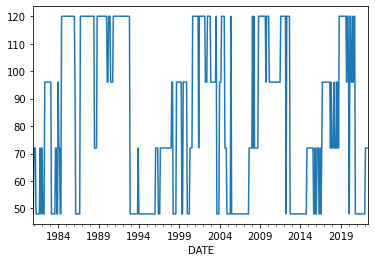

In [52]:
# Deciding the most frequent rolling period based on best predicted return criteria

best_period = stocks_fmpred.groupby(['DATE'])['bestret_period'].agg(pd.Series.mode)
best_period.plot()

<AxesSubplot:xlabel='DATE'>

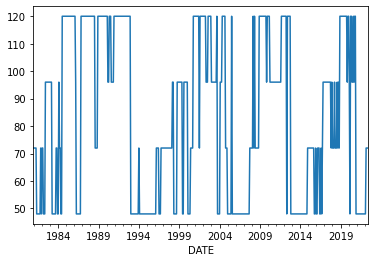

In [53]:
# Deciding the most frequent rolling period based on minimum difference criteria

minimumdiff_period = stocks_fmpred.groupby(['DATE'])['minimumdiff_period'].agg(pd.Series.mode)
minimumdiff_period.plot()

### PART4 - Performance evaluation and plotting

In [54]:
# Making functions to evalutate portfolio performance and plotting

def perf_result(epvar): 
    stocks_result['Q'] = stocks_result[epvar].groupby('DATE').apply(quintiles) 
    ports = stocks_result.groupby(['Q', 'DATE'])['RET'].mean()  # Q portfolio daily average return by quintile 
    # print(ports.groupby('Q').describe()) 
    hml = ports.loc[9] - ports.loc[0]  # high - low portfolio 
    return hml

def graph_result(epvar): 
    stocks_result['Q'] = stocks_result[epvar].groupby('DATE').apply(quintiles) 
    ports = stocks_result.groupby(['Q', 'DATE'])['RET'].mean()  # Q portfolio daily average return by quintile 
    hml = ports.loc[9] - ports.loc[0]  # high - low portfolio 
    
    comparison = pd.DataFrame(index=hml.index) 
    comparison['port'] = hml.loc['1985-01-31':] 
    comparison['port_cumprod'] = (comparison['port']+1).cumprod() 
    return comparison['port_cumprod'].plot() 

In [55]:
stocks_result = stocks_fmpred

In [56]:
# Evaluating every models' performance

Model1_48 = stats(perf_result('fmpred1_48')) # Model1(lag_BM + lag_GPA) with 48 months rolling period
Model2_48 = stats(perf_result('fmpred2_48')) # Model2(lag_BM + momentum) with 48 months rolling period
Model3_48 = stats(perf_result('fmpred3_48')) # Model3(lag_GPA + momentum) with 48 months rolling period
Model1_72 = stats(perf_result('fmpred1_72')) # Model1(lag_BM + lag_GPA) with 72 months rolling period
Model2_72 = stats(perf_result('fmpred2_72')) # Model2(lag_BM + momentum) with 72 months rolling period
Model3_72 = stats(perf_result('fmpred3_72')) # Model3(lag_GPA + momentum) with 72 months rolling period
Model1_96 = stats(perf_result('fmpred1_96')) # Model1(lag_BM + lag_GPA) with 96 months rolling period
Model2_96 = stats(perf_result('fmpred2_96')) # Model2(lag_BM + momentum) with 96 months rolling period
Model3_96 = stats(perf_result('fmpred3_96')) # Model3(lag_GPA + momentum) with 96 months rolling period
Model1_120 = stats(perf_result('fmpred1_120')) # Model1(lag_BM + lag_GPA) with 120 months rolling period
Model2_120 = stats(perf_result('fmpred2_120')) # Model2(lag_BM + momentum) with 120 months rolling period
Model3_120 = stats(perf_result('fmpred3_120')) # Model3(lag_GPA + momentum) with 120 months rolling period
pred_bestret = stats(perf_result('fmpred_bestret')) # Best predicted return model
Mindiff_ret = stats(perf_result('minimumdiff_ret')) # Minimum Difference return model
Minstd_ret = stats(perf_result('minimumstd6_ret')) # Minimum 6 months volatility model
Maxpredstd_ret = stats(perf_result('preddivstd6_ret')) # Maximum predicted return / 6 months vol model



In [57]:
# Comparing the model performance
performance = pd.DataFrame({'Model1_48':Model1_48, 'Model2_48':Model2_48,'Model3_48':Model3_48,\
                            'Model1_72':Model1_72, 'Model2_72':Model2_72,'Model3_72':Model3_72,\
                            'Model1_96':Model1_96, 'Model2_96':Model2_96,'Model3_96':Model3_96,\
                            'Model1_120':Model1_120, 'Model2_120':Model2_120,'Model3_120':Model3_120,\
                            'Pred_bestret': pred_bestret, 'Mindiff_ret' : Mindiff_ret, 'Minstd_ret':Minstd_ret, 'Maxpredstd_ret':Maxpredstd_ret})
performance 

,Model1_48,Model2_48,Model3_48,Model1_72,Model2_72,Model3_72,Model1_96,Model2_96,Model3_96,Model1_120,Model2_120,Model3_120,Pred_bestret,Mindiff_ret,Minstd_ret,Maxpredstd_ret
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.013452,0.013192,0.004360,0.016753,0.015359,0.004422,0.016918,0.016291,0.005560,0.017514,0.015206,0.005065,0.019605,0.018674,0.006261,0.019470
std,0.042839,0.060549,0.065975,0.045566,0.057402,0.066979,0.052356,0.053403,0.065785,0.052901,0.049951,0.063378,0.052519,0.049533,0.048435,0.052564
min,-0.275426,-0.539952,-0.817039,-0.273574,-0.522768,-0.831099,-0.324573,-0.351513,-0.827077,-0.321158,-0.218205,-0.757391,-0.232913,-0.217351,-0.661434,-0.233006
25%,-0.007764,-0.011285,-0.017045,-0.008474,-0.012705,-0.017837,-0.009113,-0.012540,-0.016011,-0.008465,-0.012237,-0.019173,-0.004624,-0.004536,-0.011050,-0.004640
50%,0.015866,0.012607,0.007686,0.015929,0.012281,0.009185,0.015631,0.013006,0.009591,0.016388,0.013227,0.008216,0.014929,0.015242,0.007158,0.014566
75%,0.037157,0.038255,0.032259,0.039230,0.036540,0.032441,0.038000,0.039433,0.033619,0.039031,0.036850,0.033755,0.036943,0.035733,0.024016,0.037183
max,0.186350,0.296964,0.281629,0.359230,0.313716,0.284007,0.502809,0.274103,0.293442,0.511076,0.239640,0.249522,0.346578,0.352955,0.312335,0.346578
Annual Ret,0.161418,0.158308,0.052326,0.201037,0.184306,0.053059,0.203014,0.195496,0.066722,0.210167,0.182471,0.060781,0.235262,0.224085,0.075135,0.233639
tstat,7.014277,4.867061,1.476404,8.212972,5.976982,1.474664,7.218137,6.814637,1.888036,7.395555,6.800112,1.785240,8.338759,8.421528,2.887697,8.274155


Model1 had the best performance among the three models. <br>
The longer the rolling period, the higher the average return and sharpe ratio. <br>
The best predicted return model shows the best average return and second highest sharpe ratio. <br>
The Minimum difference model shows the third highest average return and the best sharpe ratio. <br>

In [58]:
# Comparing the model performance (continued)
performance = performance[['Model1_48','Model1_72','Model1_96','Model1_120','Pred_bestret','Mindiff_ret','Maxpredstd_ret']]
performance

,Model1_48,Model1_72,Model1_96,Model1_120,Pred_bestret,Mindiff_ret,Maxpredstd_ret
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.013452,0.016753,0.016918,0.017514,0.019605,0.018674,0.019470
std,0.042839,0.045566,0.052356,0.052901,0.052519,0.049533,0.052564
min,-0.275426,-0.273574,-0.324573,-0.321158,-0.232913,-0.217351,-0.233006
25%,-0.007764,-0.008474,-0.009113,-0.008465,-0.004624,-0.004536,-0.004640
50%,0.015866,0.015929,0.015631,0.016388,0.014929,0.015242,0.014566
75%,0.037157,0.039230,0.038000,0.039031,0.036943,0.035733,0.037183
max,0.186350,0.359230,0.502809,0.511076,0.346578,0.352955,0.346578
Annual Ret,0.161418,0.201037,0.203014,0.210167,0.235262,0.224085,0.233639
tstat,7.014277,8.212972,7.218137,7.395555,8.338759,8.421528,8.274155


<AxesSubplot:xlabel='DATE'>

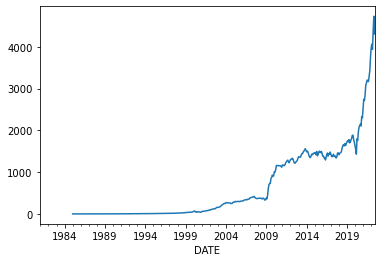

In [59]:
# best predicted return
graph_result('fmpred_bestret')

<AxesSubplot:xlabel='DATE'>

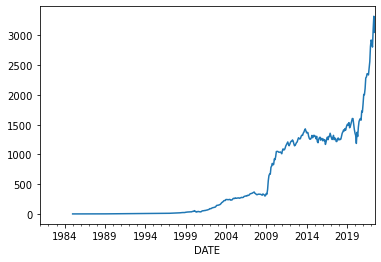

In [60]:
# Minimum difference  
graph_result('minimumdiff_ret') 

<AxesSubplot:xlabel='DATE'>

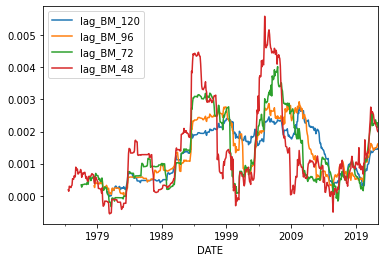

In [61]:
# Check the volatility of variable coefficient as the rolling period changes

allparams1_graph = pd.DataFrame(index=allparams1.index)
allparams1_graph['lag_BM_120'] = allparams1['lag_BM'].rolling(120).mean()
allparams1_graph['lag_BM_96'] = allparams1['lag_BM'].rolling(96).mean()
allparams1_graph['lag_BM_72'] = allparams1['lag_BM'].rolling(72).mean()
allparams1_graph['lag_BM_48'] = allparams1['lag_BM'].rolling(48).mean()

allparams1_graph.plot()

# The long the rolling period, the smaller the volatility of variable coefficient.

Other trials <br>
1. Choosing the rolling period with the best predicted return within the three models <br>
Model1 (lag_BM + lag_GPA) : fmpred1_120, fmpred1_96, fmpred1_72, fmpred1_48<br>
Model2 (lag_BM + momentum) : fmpred2_120, fmpred2_96, fmpred2_72, fmpred2_48 <br>
Model3 (lag_GPA + momentum) : fmpred3_120, fmpred3_96, fmpred3_72, fmpred3_48 <br>
<br>
2. Choosing the rolling period with the minimum difference between the predicted and actual return within the three models <br>
Model1 (lag_BM + lag_GPA) : lag_fmpred1_diff_120, lag_fmpred1_diff_96, lag_fmpred1_diff_72, lag_fmpred1_diff_48 <br>
Model2 (lag_BM + momentum) : lag_fmpred1_diff_120, lag_fmpred1_diff_96, lag_fmpred1_diff_72, lag_fmpred1_diff_48 <br>
Model3 (lag_GPA + momentum) : lag_fmpred1_diff_120, lag_fmpred1_diff_96, lag_fmpred1_diff_72, lag_fmpred1_diff_48 <br>

In [62]:
# Making some columns for choosing the best rolling periods for each model based on best predicted return and minimum difference

stocks_fmpred['bestret_period_model1'] = np.nan
stocks_fmpred['bestret_period_model2'] = np.nan
stocks_fmpred['bestret_period_model3'] = np.nan

stocks_fmpred['minimumdiff_period_model_model1'] = np.nan
stocks_fmpred['minimumdiff_period_model_model2'] = np.nan
stocks_fmpred['minimumdiff_period_model_model3'] = np.nan

stocks_fmpred['minimumdiff_ret_model1'] = np.nan
stocks_fmpred['minimumdiff_ret_model2'] = np.nan
stocks_fmpred['minimumdiff_ret_model3'] = np.nan

In [63]:
# Choosing the best rolling period for each model 

stocks_fmpred['fmpred_bestret_model1'] = stocks_fmpred[['fmpred1_120','fmpred1_96','fmpred1_72','fmpred1_48']].max(axis = 1)
stocks_fmpred['fmpred_bestret_model2'] = stocks_fmpred[['fmpred2_120','fmpred2_96','fmpred2_72','fmpred2_48']].max(axis = 1)
stocks_fmpred['fmpred_bestret_model3'] = stocks_fmpred[['fmpred3_120','fmpred3_96','fmpred3_72','fmpred3_48']].max(axis = 1)

stocks_fmpred['fmpred_minimumdiff_model1'] = stocks_fmpred[['lag_fmpred1_diff_120','lag_fmpred1_diff_96','lag_fmpred1_diff_72','lag_fmpred1_diff_48']].min(axis = 1)
stocks_fmpred['fmpred_minimumdiff_model2'] = stocks_fmpred[['lag_fmpred2_diff_120','lag_fmpred2_diff_96','lag_fmpred2_diff_72','lag_fmpred2_diff_48']].min(axis = 1)
stocks_fmpred['fmpred_minimumdiff_model3'] = stocks_fmpred[['lag_fmpred3_diff_120','lag_fmpred3_diff_96','lag_fmpred3_diff_72','lag_fmpred3_diff_48']].min(axis = 1)

In [64]:
# Making columns for the best criteria predicted returns

for p in period:
    stocks_fmpred['bestret_period_model1'].loc[(stocks_fmpred['fmpred_bestret_model1'] == stocks_fmpred['fmpred1_'+str(p)])] = str(p)
    stocks_fmpred['bestret_period_model2'].loc[(stocks_fmpred['fmpred_bestret_model2'] == stocks_fmpred['fmpred2_'+str(p)])] = str(p)  
    stocks_fmpred['bestret_period_model3'].loc[(stocks_fmpred['fmpred_bestret_model3'] == stocks_fmpred['fmpred3_'+str(p)])] = str(p)  
    
    stocks_fmpred['minimumdiff_period_model_model1'].loc[(stocks_fmpred['fmpred_minimumdiff_model1'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = str(p) + '_1'
    stocks_fmpred['minimumdiff_period_model_model2'].loc[(stocks_fmpred['fmpred_minimumdiff_model2'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])] = str(p) + '_2'    
    stocks_fmpred['minimumdiff_period_model_model3'].loc[(stocks_fmpred['fmpred_minimumdiff_model3'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])] = str(p) + '_3'      

C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\908974317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['bestret_period_model1'].loc[(stocks_fmpred['fmpred_bestret_model1'] == stocks_fmpred['fmpred1_'+str(p)])] = str(p)
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\908974317.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['bestret_period_model2'].loc[(stocks_fmpred['fmpred_bestret_model2'] == stocks_fmpred['fmpred2_'+str(p)])] = str(p)
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\908974317.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [65]:
# Deciding the best FM prediction period, model (individually)

stocks_fmpred['bestret_period_model1'] = stocks_fmpred['bestret_period_model1'].astype('int64')
stocks_fmpred['bestret_period_model2'] = stocks_fmpred['bestret_period_model2'].astype('int64')
stocks_fmpred['bestret_period_model3'] = stocks_fmpred['bestret_period_model2'].astype('int64')

stocks_fmpred['minimumdiff_period_model_model1'] = stocks_fmpred['minimumdiff_period_model_model1'].str.slice(start=0, stop=-2)
stocks_fmpred['minimumdiff_period_model_model1'] = stocks_fmpred['minimumdiff_period_model_model1'].astype('int64')
stocks_fmpred['minimumdiff_period_model_model2'] = stocks_fmpred['minimumdiff_period_model_model2'].str.slice(start=0, stop=-2)
stocks_fmpred['minimumdiff_period_model_model2'] = stocks_fmpred['minimumdiff_period_model_model2'].astype('int64')
stocks_fmpred['minimumdiff_period_model_model3'] = stocks_fmpred['minimumdiff_period_model_model3'].str.slice(start=0, stop=-2)
stocks_fmpred['minimumdiff_period_model_model3'] = stocks_fmpred['minimumdiff_period_model_model3'].astype('int64')

In [66]:
# Making columns for the best criteria predicted returns

for p in period:
    stocks_fmpred['minimumdiff_ret_model1'].loc[(stocks_fmpred['fmpred_minimumdiff_model1'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff_model1'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])]
    stocks_fmpred['minimumdiff_ret_model2'].loc[(stocks_fmpred['fmpred_minimumdiff_model2'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])] = stocks_fmpred['fmpred2_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff_model2'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)])]
    stocks_fmpred['minimumdiff_ret_model3'].loc[(stocks_fmpred['fmpred_minimumdiff_model3'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])] = stocks_fmpred['fmpred3_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff_model3'] == stocks_fmpred['lag_fmpred3_diff_'+str(p)])]

C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\3552192846.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumdiff_ret_model1'].loc[(stocks_fmpred['fmpred_minimumdiff_model1'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])] = stocks_fmpred['fmpred1_' + str(p)].loc[(stocks_fmpred['fmpred_minimumdiff_model1'] == stocks_fmpred['lag_fmpred1_diff_'+str(p)])]
C:\Users\Legion\AppData\Local\Temp\ipykernel_10236\3552192846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_fmpred['minimumdiff_ret_model2'].loc[(stocks_fmpred['fmpred_minimumdiff_model2'] == stocks_fmpred['lag_fmpred2_diff_'+str(p)

In [67]:
stocks_result = stocks_fmpred

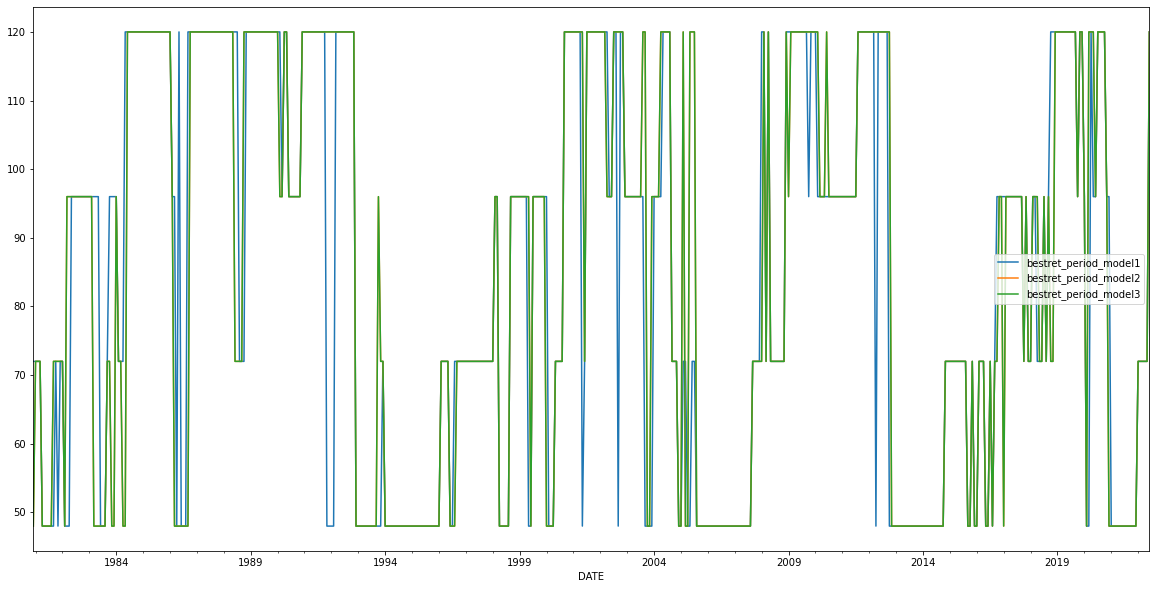

In [68]:
# Deciding the most frequent rolling period based on best predicted return criteria

best_period_model1 = stocks_fmpred.groupby(['DATE'])['bestret_period_model1'].agg(pd.Series.mode)
best_period_model2 = stocks_fmpred.groupby(['DATE'])['bestret_period_model2'].agg(pd.Series.mode)
best_period_model3 = stocks_fmpred.groupby(['DATE'])['bestret_period_model3'].agg(pd.Series.mode)

plt.figure(figsize=(20, 10))
best_period_model1.plot()
best_period_model2.plot()
best_period_model3.plot()

plt.legend()
plt.show()

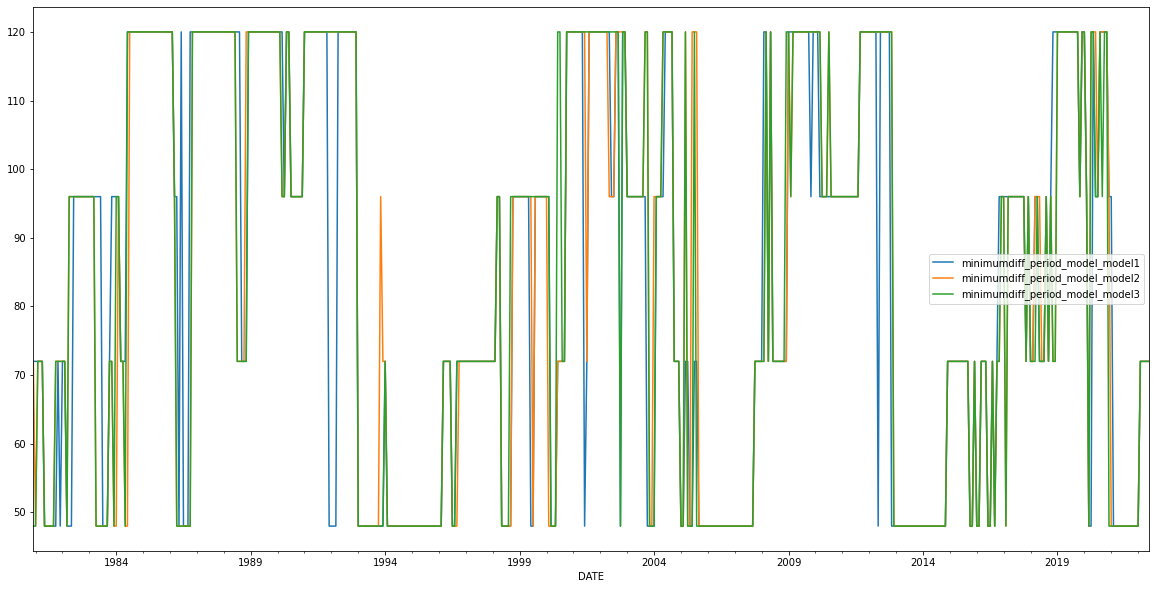

In [69]:
# Deciding the most frequent rolling period based on minimum difference criteria

minimumdiff_period_model1 = stocks_fmpred.groupby(['DATE'])['minimumdiff_period_model_model1'].agg(pd.Series.mode)
minimumdiff_period_model2 = stocks_fmpred.groupby(['DATE'])['minimumdiff_period_model_model2'].agg(pd.Series.mode)
minimumdiff_period_model3 = stocks_fmpred.groupby(['DATE'])['minimumdiff_period_model_model3'].agg(pd.Series.mode)

plt.figure(figsize=(20, 10))
minimumdiff_period_model1.plot()
minimumdiff_period_model2.plot()
minimumdiff_period_model3.plot()
plt.legend()
plt.show()

In [70]:
# Evaluating each model's performance

bestret_model1 = stats(perf_result('fmpred_bestret_model1'))
bestret_model2 = stats(perf_result('fmpred_bestret_model2'))
bestret_model3 = stats(perf_result('fmpred_bestret_model3'))
min_diff_model1 = stats(perf_result('minimumdiff_ret_model1'))
min_diff_model2 = stats(perf_result('minimumdiff_ret_model2'))
min_diff_model3 = stats(perf_result('minimumdiff_ret_model3'))

In [71]:
# Comparing the model performance
performance2 = pd.DataFrame({'bestret_model1':bestret_model1,'bestret_model2':bestret_model2,'bestret_model3':bestret_model3,\
                             'min_diff_model1':min_diff_model1, 'min_diff_model2':min_diff_model2,'min_diff_model3':min_diff_model3})
performance2 

,bestret_model1,bestret_model2,bestret_model3,min_diff_model1,min_diff_model2,min_diff_model3
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.017344,0.016539,0.005795,0.016909,0.016291,0.005923
std,0.051145,0.051631,0.061439,0.051182,0.050428,0.061125
min,-0.265210,-0.225140,-0.755646,-0.266457,-0.201805,-0.747402
25%,-0.009923,-0.011040,-0.018077,-0.010724,-0.010310,-0.018356
50%,0.016062,0.013561,0.010005,0.015513,0.013874,0.010322
75%,0.037225,0.036253,0.032952,0.036493,0.036404,0.031852
max,0.511076,0.278022,0.285632,0.511255,0.281830,0.283430
Annual Ret,0.208130,0.198465,0.069536,0.202911,0.195493,0.071073
tstat,7.575336,7.155586,2.106861,7.379977,7.216582,2.164476


Same as the previous result, Model1 had the best performance among the three models.<br>
However, the performance of portfolio is better when the optimal rolling period is selected from all models than when the optimal rolling period is selected separately for each model.

### PART5 - Comparing our model performance with benchmark portfolio

In [72]:
# Our final model : the best predicted return model

ourbest = perf_result('fmpred_bestret')
ourbest1 = pd.DataFrame(ourbest, columns=['RET'])
ourbest1.columns = ['Best_RET']
ourbest1

,Best_RET
DATE,
1980-12-31,-0.028315
1981-01-31,-0.088086
1981-02-28,-0.014929
1981-03-31,0.023596
1981-04-30,0.012565
...,...
2022-02-28,0.023381
2022-03-31,-0.030663
2022-04-30,0.110663


In [73]:
stocks_sub = stocks_fmpred
stocks_sub['DATE'] = stocks_sub.index
stocks_sub = stocks_sub.loc[stocks_sub['DATE']>'1987-12-31'] # Data from 1988-01 (Maxmium date for SPY500 TR)
stocks_sub = stocks_sub.set_index(['DATE','PERMNO'])

In [74]:
# benchmark_1 : Equally weighted portfolio in every stocks
benchret = stocks_sub[['RET']].groupby('DATE').mean() 
benchret.head()

,RET
DATE,
1988-01-31,0.075655
1988-02-29,0.072636
1988-03-31,0.041090
1988-04-30,0.016991
1988-05-31,-0.018639


In [75]:
# benchmark_2 : SPY ETF return (using ^SP500TR)
spydata              = yf.Ticker('^SP500TR').history(period="max")
spydata.index.names  = ['DATE']
spydata['DAYRET']    = (spydata['Close']+spydata['Dividends']) / spydata['Close'].shift() - 1
spydata['PORTVAL']   = (1 + spydata['DAYRET']).cumprod() 
spydata['yearmonth'] = spydata.index.year*100 + spydata.index.month
spydata              = spydata.loc[spydata['yearmonth'] < spydata['yearmonth'].shift(-1)] 
spydata['RET']       = spydata['PORTVAL'].pct_change() 
spydata['DATE']      = pd.to_datetime(spydata.index.date) + MonthEnd(0)
spydata              = spydata.reset_index(drop=True).set_index('DATE') 
spydata.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,DAYRET,PORTVAL,yearmonth,RET
DATE,,,,,,,,,,,
1988-01-31,257.470001,257.470001,257.470001,257.470001,0,0,0,0.014980,1.005664,198801,NaN
1988-02-29,269.480011,269.480011,269.480011,269.480011,0,0,0,0.020796,1.052574,198802,0.046646
1988-03-31,261.149994,261.149994,261.149994,261.149994,0,0,0,0.003188,1.020038,198803,-0.030911
1988-04-30,264.040009,264.040009,264.040009,264.040009,0,0,0,-0.004824,1.031326,198804,0.011066
1988-05-31,266.320007,266.320007,266.320007,266.320007,0,0,0,0.034654,1.040231,198805,0.008635


In [76]:
# T-bill yield calculation
irxdata              = yf.Ticker('^IRX').history(period="max")
irxdata.index.names  = ['DATE']
irxdata['yearmonth'] = irxdata.index.year*100 + irxdata.index.month
irxdata              = irxdata.loc[irxdata['yearmonth'] < irxdata['yearmonth'].shift(-1)]
irxdata['rfret']     = irxdata['Close'].shift() / 100 / 12
irxdata              = irxdata[['rfret']].dropna()
irxdata['DATE']      = pd.to_datetime(irxdata.index.date) + MonthEnd(0)
irxdata              = irxdata.reset_index(drop=True).set_index('DATE')
irxdata.head()

,rfret
DATE,
1960-02-29,0.003325
1960-03-31,0.003492
1960-04-30,0.002517
1960-05-31,0.002533
1960-06-30,0.002600


In [77]:
# Calculating the Excess return for benchmark1, benchmark2, and our best model

benchret['SPYRET'] = spydata['RET']
benchret           = benchret.merge(irxdata, how='left', on='DATE')
benchret           = pd.merge(benchret, ourbest1, how='left', on='DATE')

benchret['RET']    = benchret['RET']    - benchret['rfret']
benchret['SPYRET'] = benchret['SPYRET'] - benchret['rfret']

In [78]:
# Making functions for benchmark comparison

def stats2(hml):
    stats = hml.describe()
    stats.loc['Annual Ret'] = stats.loc['mean'] * 12
    stats.loc['tstat'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)

### Period is sliced below hml.index     
    
    performance = pd.DataFrame(index=hml.index)
    performance['port_ret'] = hml['port']
    performance['cumprod'] = (performance['port_ret']+1).cumprod()
    performance['cummax'] = performance['cumprod'].cummax()
    performance['drawdown'] = -(performance['cumprod']/performance['cummax'] - 1)
    stats.loc['Max DD','port'] = performance['drawdown'].max()

    performance['port_RET-rf'] = hml['RET-rf']    
    performance['cumprod_RET-rf'] = (performance['port_RET-rf']+1).cumprod()    
    performance['cummax_RET-rf'] = performance['cumprod_RET-rf'].cummax()
    performance['drawdown_RET-rf'] = -(performance['cumprod_RET-rf']/performance['cummax_RET-rf'] - 1)
    stats.loc['Max DD','RET-rf'] = performance['drawdown_RET-rf'].max() 

    performance['port_SPY-rf'] = hml['SPY-rf']    
    performance['cumprod_SPY-rf'] = (performance['port_SPY-rf']+1).cumprod()        
    performance['cummax_SPY-rf'] = performance['cumprod_SPY-rf'].cummax()
    performance['drawdown_SPY-rf'] = -(performance['cumprod_SPY-rf']/performance['cummax_SPY-rf'] - 1)
    stats.loc['Max DD','SPY-rf'] = performance['drawdown_SPY-rf'].max() 

    
    stats.loc['STDEV_Annual'] = stats.loc['std'] * np.sqrt(12)
    
    performance['minX'] = 0
    performance.loc[performance['port_ret']<0, 'minX'] = performance['port_ret']
    DDeviation_port = np.sqrt(12) * (performance['minX']**2).mean() ** .5
    stats.loc['Downside Deviation_Annual','port'] = DDeviation_port
    Sortino_port = stats.loc['mean','port'] * 12 / DDeviation_port
    stats.loc['Sortino','port'] =  Sortino_port

    performance['minX_RET-rf'] = 0
    performance.loc[performance['port_RET-rf']<0, 'minX_RET-rf'] = performance['port_RET-rf']
    DDeviation_RETrf = np.sqrt(12) * (performance['minX_RET-rf']**2).mean() ** .5
    stats.loc['Downside Deviation_Annual','RET-rf'] = DDeviation_RETrf
    Sortino_RETrf = stats.loc['mean','RET-rf'] * 12 / DDeviation_RETrf
    stats.loc['Sortino','RET-rf'] =  Sortino_RETrf
    
    performance['minX_SPY-rf'] = 0
    performance.loc[performance['port_SPY-rf']<0, 'minX_SPY-rf'] = performance['port_SPY-rf']
    DDeviation_SPYrf = np.sqrt(12) * (performance['minX_SPY-rf']**2).mean() ** .5
    stats.loc['Downside Deviation_Annual','SPY-rf'] = DDeviation_SPYrf
    Sortino_SPYrf = stats.loc['mean','SPY-rf'] * 12 / DDeviation_SPYrf
    stats.loc['Sortino','SPY-rf'] =  Sortino_SPYrf
        
    print(stats)

In [79]:
# Making functions for benchmark comparison

def graph_result_withBM(epvar,period1,period2): 
    stocks_result['Q'] = stocks_result[epvar].groupby('DATE').apply(quintiles) 
    ports = stocks_result.groupby(['Q', 'DATE'])['RET'].mean()  
    
    hml = ports.loc[9] - ports.loc[0]   
    hml = hml.loc[period1:period2]
    
    comparison = pd.DataFrame(index=hml.index) 
    comparison['port'] = hml 
    comparison['RET-rf'] = benchret['RET']
    comparison['SPY-rf'] = benchret['SPYRET']
    
    comparison_graph = pd.DataFrame(index=hml.index)
    comparison_graph['port_cumprod'] = (comparison['port']+1).cumprod() 
    comparison_graph['port_cumprod'].plot() 
    comparison_graph['BM_RET-rf'] = (comparison['RET-rf']+1).cumprod()
    comparison_graph['BM_SPYRET-rf'] = (comparison['SPY-rf']+1).cumprod()
    comparison_graph['BM_RET-rf'].plot()
    comparison_graph['BM_SPYRET-rf'].plot()
    plt.legend()
    plt.show()

    stats2(comparison)

In [80]:
stocks_result.drop(columns=['DATE'], inplace=True)

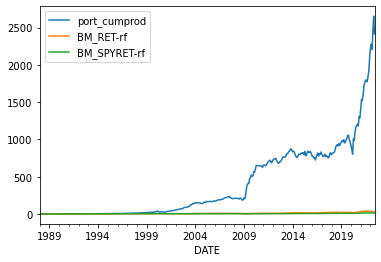

                                 port      RET-rf      SPY-rf
count                      414.000000  414.000000  413.000000
mean                         0.020390    0.009714    0.006919
std                          0.054770    0.057300    0.042069
min                         -0.232913   -0.227130   -0.168701
25%                         -0.004201   -0.022486   -0.016702
50%                          0.014394    0.012291    0.010625
75%                          0.036337    0.040023    0.034091
max                          0.346578    0.240086    0.128169
Annual Ret                   0.244686    0.116566    0.083028
tstat                        7.575079    3.449335    3.342341
sharpe                       1.289667    0.587254    0.569726
Max DD                       0.433483    0.603313    0.555544
STDEV_Annual                 0.189728    0.198494    0.145733
Downside Deviation_Annual    0.079698    0.127183    0.098591
Sortino                      3.070146    0.916526    0.842149


In [81]:
# Benchmark comparison from 1988-01-31 to 2022-06-30 (Whole period)
graph_result_withBM('fmpred_bestret','1988-01-31','2022-06-30')

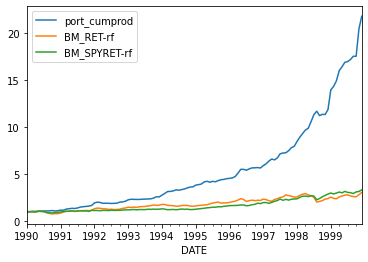

                                 port      RET-rf      SPY-rf
count                      120.000000  120.000000  120.000000
mean                         0.026640    0.010494    0.010737
std                          0.036170    0.049599    0.038791
min                         -0.048664   -0.204796   -0.148705
25%                          0.004299   -0.023204   -0.012355
50%                          0.021025    0.017222    0.013080
75%                          0.041544    0.038288    0.036772
max                          0.176311    0.154427    0.110731
Annual Ret                   0.319680    0.125924    0.128841
tstat                        8.068102    2.317651    3.032016
sharpe                       2.551358    0.732906    0.958808
Max DD                       0.069192    0.313980    0.174090
STDEV_Annual                 0.125298    0.171814    0.134376
Downside Deviation_Annual    0.028753    0.110926    0.083829
Sortino                     11.118110    1.135210    1.536951


In [82]:
# Benchmark comparison from 1990-01-31 to 1999-12-31 
graph_result_withBM('fmpred_bestret','1990-01-31','1999-12-31')

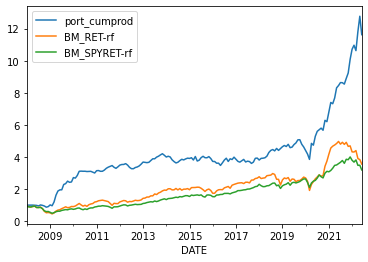

                                 port      RET-rf      SPY-rf
count                      174.000000  174.000000  174.000000
mean                         0.015560    0.009361    0.007792
std                          0.054699    0.063319    0.046094
min                         -0.089710   -0.227130   -0.168701
25%                         -0.014498   -0.021146   -0.015376
50%                          0.010867    0.014436    0.013472
75%                          0.030086    0.042733    0.035880
max                          0.346578    0.220535    0.128169
Annual Ret                   0.186718    0.112328    0.093498
tstat                        3.752298    1.950051    2.229727
sharpe                       0.985402    0.512108    0.585555
Max DD                       0.240792    0.507758    0.468197
STDEV_Annual                 0.189484    0.219344    0.159674
Downside Deviation_Annual    0.070578    0.145568    0.109972
Sortino                      2.645561    0.771648    0.850203


In [83]:
# Benchmark comparison from 2008-01-31 to 2022-06-30 (Recent years)
graph_result_withBM('fmpred_bestret','2008-01-31','2022-06-30')

In [84]:
def graph_result_multi(epvar,period1,period2): 
    stocks_result['Q'] = stocks_result[epvar].groupby('DATE').apply(quintiles) 
    ports = stocks_result.groupby(['Q', 'DATE'])['RET'].mean()
    
    hml = ports.loc[9] - ports.loc[0]  # high - low 
    hml = hml.loc[period1:period2]
    
    comparison = pd.DataFrame(index=hml.index)
    comparison['port'] = hml
    
    comparison_graph = pd.DataFrame(index=hml.index)
    comparison_graph[epvar] = (comparison['port']+1).cumprod()
    return comparison_graph[epvar]


In [85]:
fmpred_bestret_model1 = graph_result_multi('fmpred_bestret_model1','1996-01-31','2022-06-30')
fmpred_bestret_model2 = graph_result_multi('fmpred_bestret_model2','1996-01-31','2022-06-30')
fmpred_bestret_model3 = graph_result_multi('fmpred_bestret_model2','1996-01-31','2022-06-30')
fmpred1_120 = graph_result_multi('fmpred1_120','1996-01-31','2022-06-30')
fmpred2_120 = graph_result_multi('fmpred2_120','1996-01-31','2022-06-30')
fmpred3_120 = graph_result_multi('fmpred3_120','1996-01-31','2022-06-30')
fmpred1_48 = graph_result_multi('fmpred1_48','1996-01-31','2022-06-30')
fmpred2_48 = graph_result_multi('fmpred2_48','1996-01-31','2022-06-30')
fmpred3_48 = graph_result_multi('fmpred3_48','1996-01-31','2022-06-30')
Dynamic2_HighRet = graph_result_multi('fmpred_bestret','1996-01-31','2022-06-30')
Dynamic2_MinErr = graph_result_multi('minimumdiff_ret','1996-01-31','2022-06-30')

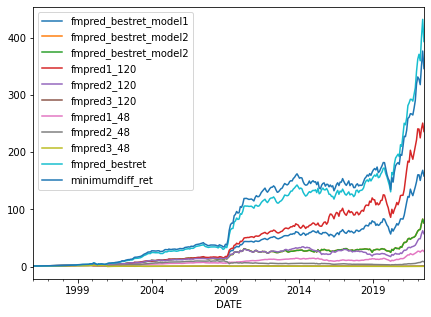

In [86]:
plt.figure(figsize=(7, 5))
fmpred_bestret_model1.plot()
fmpred_bestret_model2.plot()
fmpred_bestret_model3.plot()
fmpred1_120.plot()
fmpred2_120.plot()
fmpred3_120.plot()
fmpred1_48.plot()
fmpred2_48.plot()
fmpred3_48.plot()
Dynamic2_HighRet.plot()
Dynamic2_MinErr.plot()
plt.legend()
plt.show()